## 00. 환경설정

In [1]:
from collections import OrderedDict, defaultdict
from copy import copy
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

from sklearn.metrics import log_loss, roc_auc_score
import tensorflow as tf
K = tf.keras.backend

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 01. Candidate Generation 구현
- Youtube Recommendaion의 모델은 사용자의 과거 히스토리, 영상의 나이 등의 피쳐를 사용해서 후보 아이템을 예측합니다
- 우리는 광고 클릭 로그를 사용하기 때문에 사용하는 피쳐도 달라지고 모델의 구조도 약간 달라지게 됩니다

### 광고 클릭 로그로 Candidate Generation 모델 학습
- 광고 클릭 로그 가운데 click = 1인 로그만을 사용하여 CG 모델을 학습합니다 (CF와 비슷한 컨셉, click = 0인 로그는 아예 사용하지 않음)
- 우리는 모델의 input feature(X)로 유저, 매체, 디바이스와 관련된 피쳐를 사용하고, 예측할 아이템(y)은 광고의 최소 단위인 소재(C14)를 사용합니다
- 정리하면 우리의 CG 모델은 주어진 유저, 매체, 디바이스 피쳐에 대해서 가장 클릭할 확률이 높은 광고(C14)를 예측하는 것입니다

In [2]:
file_path = '../data/avazu-ctr-prediction/ad_click.csv'

In [3]:
parse_date = lambda x : datetime.strptime(x, '%y%m%d%H').strftime('%Y-%m-%d')
click_df = pd.read_csv(file_path, parse_dates = ['datetime'], date_parser = parse_date, header=0)

In [4]:
click_df = click_df[[
    'click', 'datetime', 'banner_pos', 'site_id', 'site_domain',
    'site_category', 'app_id', 'app_domain', 'app_category',
    'device_model', 'device_type', 'device_conn_type',
    'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'
]]

#### Candidate Generation 모델의 개별 피쳐
- 피쳐별로 이름과 피쳐의 최대 개수(size)를 선언해줍니다.
- ex) 성별의 경우 남자, 여자 => 2

In [5]:
class Feature:
    def __init__(self, name, size, embedding_dim):
        self.name = name
        self.size = size
        self.embedding_dim = embedding_dim

In [6]:
click_df

,click,datetime,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,...,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21
0,0,2014-10-21,0,da79c793,71ed77a0,f028772b,ecad2386,7801e8d9,07d7df22,fce66524,...,0,1005,18993,320,50,2161,0,35,-1,157
1,0,2014-10-21,1,85f751fd,c4e18dd6,50e219e0,8c0dcd5a,7801e8d9,0f2161f8,1df52df3,...,0,1010,21665,320,50,2493,3,35,-1,117
2,0,2014-10-21,0,61a8c644,948ff336,50e219e0,ecad2386,7801e8d9,07d7df22,72dab84d,...,0,1002,19665,320,50,2253,2,303,-1,52
3,1,2014-10-21,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,8a4875bd,...,0,1005,15706,320,50,1722,0,35,-1,79
4,0,2014-10-21,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,cdfde03b,...,0,1005,20362,320,50,2333,0,39,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,2014-10-30,1,57fe1b20,5b626596,f028772b,ecad2386,7801e8d9,07d7df22,56e6ab1d,...,0,1005,23722,320,50,2716,3,47,-1,23
199996,0,2014-10-30,0,85f751fd,c4e18dd6,50e219e0,53de0284,d9b5648e,0f2161f8,99e427c9,...,0,1005,21706,320,50,2498,3,41,100111,61
199997,0,2014-10-30,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,0fadd2fe,...,0,1005,22676,320,50,2616,0,35,-1,51
199998,0,2014-10-30,0,c135a32f,b8393312,50e219e0,ecad2386,7801e8d9,07d7df22,08ac11ab,...,0,1002,17894,320,50,2039,2,39,100077,32


In [7]:
from sklearn.preprocessing import LabelEncoder

features = [
    'banner_pos', 'site_id', 'site_domain','site_category', 'app_id', 'app_domain',
    'app_category', 'device_model', 'device_type', 'device_conn_type'
]

click_df[features] = click_df[features].fillna('-1')
target = ['C14']

# 각 피쳐와 예측 아이템에 대해서 0 이상의 자연수로 indexing 해줍니다
for feat in features + target:
    lbe = LabelEncoder()
    click_df[feat] = lbe.fit_transform(click_df[feat])

embedding_dim = 4
feature_columns = [Feature(feat, click_df[feat].nunique(), embedding_dim) for i, feat in enumerate(features)]
num_classes = click_df['C14'].nunique()

In [8]:
# 예측할 클릭 아이템의 총 class 개수
num_classes

1934

In [9]:
# 사용할 feature의 dimension
for feature in feature_columns:
    print(feature.name + ':', feature.size)

banner_pos: 7
site_id: 1804
site_domain: 1711
site_category: 20
app_id: 1776
app_domain: 112
app_category: 22
device_model: 3751
device_type: 4
device_conn_type: 4


In [10]:
# click = 1인 데이터만 CG 모델에 사용합니다, click = 0은 아예 사용하지 않습니다
cg_df = click_df[click_df['click'] > 0]

In [11]:
cg_df[features + target]

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,device_type,device_conn_type,C14
3,1,1541,1029,18,1648,43,0,2011,1,0,202
13,0,949,1316,5,77,26,20,113,1,0,375
20,0,949,1316,5,1128,43,0,3736,0,0,730
29,0,217,1620,1,1648,43,0,2503,1,0,203
32,0,217,1620,1,1648,43,0,1793,1,0,198
...,...,...,...,...,...,...,...,...,...,...,...
199972,0,949,1316,5,1078,13,20,451,1,0,1567
199980,0,217,1620,1,1648,43,0,2794,1,0,1072
199982,0,949,1316,5,1078,13,20,451,1,0,1566
199986,0,546,725,1,1648,43,0,109,1,0,261


In [12]:
# 날짜를 기준으로 train과 test 데이터를 나눕니다

train_df = cg_df[cg_df['datetime'] <= '2014-10-28']
test_df = cg_df[cg_df['datetime'] > '2014-10-28']

In [13]:
# train / test 데이터를 생성합니다

train_X = [train_df[name].values for name in features]
train_y = train_df[target].values
test_X = [test_df[name].values for name in features]
test_y = test_df[target].values

In [14]:
# 모델의 input으로 사용할 X
train_X

[array([1, 0, 0, ..., 0, 0, 0]),
 array([1541,  949,  949, ...,  217,  949,  949]),
 array([1029, 1316, 1316, ..., 1620, 1316, 1316]),
 array([18,  5,  5, ...,  1,  5,  5]),
 array([1648,   77, 1128, ..., 1648,  781, 1579]),
 array([43, 26, 43, ..., 43, 13, 34]),
 array([ 0, 20,  0, ...,  0, 12,  3]),
 array([2011,  113, 3736, ..., 1732,  722, 1287]),
 array([1, 1, 0, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [15]:
# 모델이 예측해야 할 y
train_y

array([[ 202],
       [ 375],
       [ 730],
       ...,
       [1074],
       [1555],
       [1241]])

### Candidate Generation Model 구현

In [16]:
# DNN Custom Layer

class DNN(tf.keras.layers.Layer):
    """
      Input shape
      - 2D tensor: ``(batch_size, input_dim)``.
      Output shape
      - 2D tensor: ``(batch_size, hidden_size[-1])``.
    """
    def __init__(self, hidden_units, activation='relu', **kwargs):
        self.hidden_units = hidden_units
        self.activation = activation

        super(DNN, self).__init__(**kwargs)

    def build(self, input_shape):

        if len(self.hidden_units) == 0:
            raise ValueError("hidden_units is empty")
        
        # DNN Layer는 각 hidden layer의 weight와 bias를 학습 파라미터로 선언합니다
        
        input_size = input_shape[-1]
        hidden_units = [int(input_size)] + list(self.hidden_units)
        self.kernels = [self.add_weight(name='kernel' + str(i),
                                        shape=(hidden_units[i], hidden_units[i + 1]),
                                        initializer=tf.keras.initializers.glorot_normal(),
                                        trainable=True
                                        ) for i in range(len(self.hidden_units))]
        self.bias = [self.add_weight(name='bias' + str(i),
                                     shape=(self.hidden_units[i],),
                                     initializer=tf.keras.initializers.Zeros(),
                                     trainable=True
                                     ) for i in range(len(self.hidden_units))]

        self.activation_layers = [tf.keras.layers.Activation(self.activation) for _ in range(len(self.hidden_units))]

        super(DNN, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs, training=None, **kwargs):

        deep_input = inputs
        
        # hidden layer의 개수만큼 loop를 돌면서 layer를 계속 쌓아줍니다

        for i in range(len(self.hidden_units)):
            fc = tf.nn.bias_add(tf.tensordot(deep_input, self.kernels[i], axes=(-1, 0)), self.bias[i])
            fc = self.activation_layers[i](fc)
            deep_input = fc

        return deep_input

    def compute_output_shape(self, input_shape):
        if len(self.hidden_units) > 0:
            shape = input_shape[:-1] + (self.hidden_units[-1], )
        else:
            shape = input_shape
        return tuple(shape)

    def get_config(self):
        config = {'activation': self.activation, 'hidden_units': self.hidden_units}
        base_config = super(DNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [17]:
# negative sampling이 구현된 custom softmax layer

class NCE(tf.keras.layers.Layer):
    def __init__(self, num_classes, neg_samples=5, **kwargs):
        
        # multi-class 분류 문제의 class 개수 => num_classes
        # negative sampling을 사용한 cross entropy를 계산합니다 => neg_samples
        
        self.num_classes = num_classes
        self.neg_samples = neg_samples
        super(NCE, self).__init__(**kwargs)

    def build(self, input_shape):
        
        # softmax output layer에 필요한 weight 선언
        self.W = self.add_weight(
            name="softmax_weights",
            shape=(self.num_classes, input_shape[0][1]),
            initializer="glorot_normal",
        )

        # keras
        super(NCE, self).build(input_shape)

    # keras Layer interface
    def call(self, x, training=False):
        predictions, targets = x
        
        # 학습할 때는 negative sampled cross entropy를 사용합니다
        if training:
            loss = tf.nn.sampled_softmax_loss(
                self.W, tf.zeros(shape=(self.num_classes,)), targets, predictions, self.neg_samples, self.num_classes
            )
        
        # 성능을 평가할 때는 전체 class에 대한 cross entropy를 사용합니다
        else:
            logits = K.dot(predictions, K.transpose(self.W))
            labels_one_hot = tf.one_hot(targets, self.num_classes)
            loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels_one_hot, logits=logits)

        # keras
        self.add_loss(loss)

        logits = K.dot(predictions, K.transpose(self.W))
        softmax = tf.nn.softmax(logits)

        return softmax

    # keras Layer interface
    def compute_output_shape(self, input_shape):
        return tuple((self.num_classes, ))

In [18]:
def CandidateGenration(feature_columns, num_classes, neg_samples, dnn_hidden_units=(64, 32), dnn_activation='relu', name = 'CG'):
    
    # feature별로 tensorflow keras input을 선언합니다
    input_dict = OrderedDict()
    for feat in feature_columns:
        input_dict[feat.name] = tf.keras.layers.Input(shape=(1,), name=feat.name)
    
    # feature들을 모델의 input으로 사용합니다
    inputs = list(input_dict.values())
    # 클릭한 아이템의 class도 모델의 input으로 받습니다
    targets = tf.keras.layers.Input(shape=(1,), dtype='int32', name='target_class')
    
    # 개별 feature의 input을 embedding 해줍니다
    embeddings = [tf.keras.layers.Embedding(feat.size, feat.embedding_dim,
                                            embeddings_initializer=tf.keras.initializers.RandomNormal(),
                                            trainable=True,
                                            name='emb_' + feat.name)(input_dict[feat.name]) for feat in feature_columns]
    
    # embedding한 개별 피쳐를 concat해줍니다
    embeddings_concat = tf.keras.layers.Concatenate(axis=-1, name = 'embeddings_concat')(embeddings)
    
    # concat한 layer를 dnn의 input으로 넣어줍니다
    dnn_input = tf.keras.layers.Flatten(name='dnn_input')(embeddings_concat)
    dnn_output = DNN(hidden_units=dnn_hidden_units, name='dnn_output')(dnn_input)
    
    # dnn의 output을 softmax layer에 통과시켜 class 개수에 해당하는 softmax 값을 최종 output으로 출력합니다
    # 이 때 negative sampling을 사용한 cross entropy를 계산하여 학습에 사용합니다
    softmax = NCE(num_classes, neg_samples, name="nce")([dnn_output, targets])
    
    # 마지막으로 input과 output을 맞춰서 keras model을 완성시킵니다
    model = tf.keras.models.Model(inputs=[inputs, targets], outputs=[softmax], name = name)
    model.compile(optimizer="adam", loss=None)
    
    return model

## 02. train 데이터로 모델 학습

In [19]:
# tensorflow keras 모델 선언
neg_samples = 100
dnn_hidden_units = (64, 32)
model = CandidateGenration(feature_columns, num_classes, neg_samples, dnn_hidden_units, dnn_activation='relu')

In [20]:
# 모델 구조를 살펴봅시다
model.summary()

Model: "CG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
banner_pos (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_domain (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
site_category (InputLayer)      [(None, 1)]          0                                            
_________________________________________________________________________________________________

In [21]:
# train 데이터로 모델을 학습하고 test 데이터로 validation을 해봅니다
# 이 때 training loss와 validation loss의 차이가 큰 이유는, training을 할 때는 negative sampled cross entropy를 사용하고
# validation 할 때는 전체 class에 대한 cross entropy를 계산하기 때문입니다

history = model.fit([train_X, train_y], batch_size=64, epochs=20, verbose=1, validation_data=([test_X, test_y]))

Epoch 1/20
430/430 [==============================] - 1s 2ms/step - loss: 3.0525 - val_loss: 6.5711
Epoch 2/20
430/430 [==============================] - 1s 2ms/step - loss: 2.2006 - val_loss: 6.4053
Epoch 3/20
430/430 [==============================] - 1s 2ms/step - loss: 1.7788 - val_loss: 6.4979
Epoch 4/20
430/430 [==============================] - 1s 2ms/step - loss: 1.5596 - val_loss: 6.6558
Epoch 5/20
430/430 [==============================] - 1s 2ms/step - loss: 1.3891 - val_loss: 6.8898
Epoch 6/20
430/430 [==============================] - 1s 2ms/step - loss: 1.2962 - val_loss: 6.7830
Epoch 7/20
430/430 [==============================] - 1s 2ms/step - loss: 1.1825 - val_loss: 7.0278
Epoch 8/20
430/430 [==============================] - 1s 2ms/step - loss: 1.0902 - val_loss: 7.1221
Epoch 9/20
430/430 [==============================] - 1s 3ms/step - loss: 1.0567 - val_loss: 7.2772
Epoch 10/20
430/430 [==============================] - 1s 2ms/step - loss: 1.0052 - val_loss: 7.4724

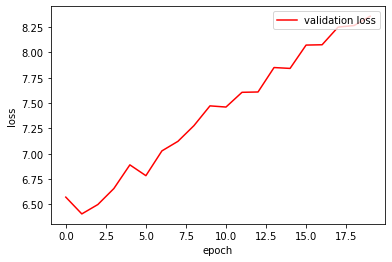

In [22]:
# training loss와 validation loss

fig, loss_ax = plt.subplots()
loss_ax.plot(history.history['val_loss'], 'r', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

plt.show()

## 03. Top K 추천 성능 평가

In [23]:
# epoch = 1로 학습한 모델로 Top N 추천 성능을 평가해봅시다

neg_samples = 100
dnn_hidden_units = (64, 32)
model = CandidateGenration(feature_columns, num_classes, neg_samples, dnn_hidden_units, dnn_activation='relu')
model.fit([train_X, train_y], batch_size=64, epochs=2, verbose=1, validation_data=([test_X, test_y]))

Epoch 1/2
430/430 [==============================] - 1s 2ms/step - loss: 3.0568 - val_loss: 6.4645
Epoch 2/2
430/430 [==============================] - 1s 2ms/step - loss: 2.1408 - val_loss: 6.3629


In [24]:
# test 데이터(X)로 예측을 수행합니다
# 여기서 test_y는 아무런 역할도 수행하지 않습니다

softmax = model.predict([test_X, test_y])

In [25]:
test_X

[array([0, 0, 0, ..., 0, 0, 0]),
 array([220, 217, 217, ..., 949, 546, 949]),
 array([1316, 1620, 1620, ..., 1316,  725, 1316]),
 array([5, 1, 1, ..., 5, 1, 5]),
 array([1648, 1648, 1648, ..., 1078, 1648, 1078]),
 array([43, 43, 43, ..., 13, 43, 13]),
 array([ 0,  0,  0, ..., 20,  0, 20]),
 array([ 808, 1141, 2974, ...,  451,  109,  641]),
 array([0, 1, 1, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [26]:
softmax.shape

(6543, 1934)

In [27]:
# test 데이터의 X에 대해서 1934개의 class에 대한 확률값을 얻습니다
# 가장 확률이 높은 10개의 아이템을 선정해봅시다

n = 10
recommends = [list((-arr).argsort()[:n]) for arr in softmax]

In [28]:
recommends

[[26, 547, 1555, 200, 548, 815, 47, 546, 268, 253],
 [200, 462, 195, 201, 197, 202, 204, 199, 203, 198],
 [200, 462, 195, 201, 197, 202, 204, 199, 203, 198],
 [26, 281, 266, 272, 247, 251, 519, 264, 485, 994],
 [26, 547, 1555, 548, 538, 686, 546, 14, 799, 12],
 [26, 547, 1555, 200, 548, 815, 47, 546, 268, 253],
 [200, 462, 195, 201, 197, 202, 204, 199, 203, 198],
 [200, 462, 195, 201, 197, 202, 204, 199, 203, 198],
 [200, 462, 195, 201, 197, 202, 204, 199, 203, 198],
 [26, 281, 266, 247, 272, 251, 519, 264, 547, 994],
 [274, 273, 461, 377, 485, 243, 376, 263, 218, 422],
 [26, 547, 1555, 538, 686, 548, 546, 14, 799, 815],
 [26, 281, 266, 272, 247, 251, 519, 264, 485, 547],
 [26, 281, 266, 272, 247, 251, 519, 264, 485, 547],
 [26, 281, 266, 247, 272, 251, 519, 264, 547, 994],
 [26, 547, 548, 1555, 546, 47, 799, 281, 815, 994],
 [200, 462, 195, 201, 197, 202, 204, 199, 203, 198],
 [200, 462, 1555, 507, 195, 197, 201, 204, 202, 508],
 [26, 1555, 519, 485, 47, 547, 507, 235, 281, 1275],
 [2

In [29]:
test_y

array([[1662],
       [1272],
       [ 197],
       ...,
       [1566],
       [ 261],
       [1567]])

In [30]:
# test 데이터에 대해서 실제로 클릭한 아이템(test_y)과 top_n을 비교하여 hit_ratio를 구해봅니다

hit = 0
for true_label, top_n in zip(test_y, recommends):
    if true_label[0] in top_n:
        hit += 1
print('hit_ratio: ', hit / len(test_y))

hit_ratio:  0.27342197768607673
